# **Class 2: Text preparation**

# **Set up environment**

In [50]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import collections
from collections import Counter
from itertools import chain
import string
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import RegexpTokenizer
from nltk.text import Text
from wordcloud import WordCloud

In [51]:
# Download additional NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [52]:
# Enable scrolling to view whole dataframe
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

# **Upload and read in files**

In [53]:
# Mount your Google Drive, then all files in Drive are accessible via Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# Read in either the .csv file or the .pkl file you saved from last class
df = pd.read_csv('/content/drive/MyDrive/LA2/df.csv')
df.head()

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length
0,058-Legacy-Church-Inc-v-Kunkel.txt,472 F.Supp.3d 926 United States District Co...,"Legacy Church v. Kunkel, 472 F.Supp.3d 926",472 F.Supp.3d 926,7/13/2020,DC_New Mexico,federal,trial,New Mexico,570933
1,023-Hernandez-v-Grisham.txt,KeyCite Yellow Flag - Negative Treatment ...,"Hernandez v. Grisham, 508 F.Supp.3d 893",508 F.Supp.3d 893,12/18/2020,DC_New Mexico,federal,trial,New Mexico,361480
2,004-Adams-And-Boyle-PC-v-Slatery.txt,KeyCite Red Flag - Severe Negative Treatme...,"Adams & Boyle v. Slatery, 494 F.Supp.3d 488",494 F.Supp.3d 488,10/14/2020,DC_Tennessee Middle,federal,trial,Tennessee,301342
3,31-Melendez-v-City-of-New-York.txt,KeyCite Yellow Flag - Negative Treatment ...,"Melendez v. City of New York, 16 F.4th 992",16 F.4th 992,11/25/2020,DC_New York Southern,federal,trial,New York,292435
4,72-Wisconsin-Legislature-v-Palm_1.txt,KeyCite Yellow Flag - Negative Treatment ...,"Wisconsin Legislature v. Palm, 391 Wis.2d 497",391 Wis.2d 497,NaN,NaN,NaN,NaN,NaN,268083


# **Text preparation**

**Segmentation**

In [55]:
# Split out different parts of document:
# Synopsis (and header material before)
# Holdings
# Procedural posture(s)
# Attorneys and Law Firms

# How to identify the beginning of the opinion?

# Majority, concurrence, dissent
# "All citations"
# Footnotes
# "End of document" material

# This is going to be a task we'll work on for a while

In [56]:
# Problem is that different opinions have different formats depending on the court
# We'll just work with the federal trial level courts ("dc" for district courts) for simplicity for now
# Create a subset of the main dataframe
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

dc_df = df[df['trial_appellate'] == 'trial']
dc_df.head()

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length
0,058-Legacy-Church-Inc-v-Kunkel.txt,472 F.Supp.3d 926 United States District Co...,"Legacy Church v. Kunkel, 472 F.Supp.3d 926",472 F.Supp.3d 926,7/13/2020,DC_New Mexico,federal,trial,New Mexico,570933
1,023-Hernandez-v-Grisham.txt,KeyCite Yellow Flag - Negative Treatment ...,"Hernandez v. Grisham, 508 F.Supp.3d 893",508 F.Supp.3d 893,12/18/2020,DC_New Mexico,federal,trial,New Mexico,361480
2,004-Adams-And-Boyle-PC-v-Slatery.txt,KeyCite Red Flag - Severe Negative Treatme...,"Adams & Boyle v. Slatery, 494 F.Supp.3d 488",494 F.Supp.3d 488,10/14/2020,DC_Tennessee Middle,federal,trial,Tennessee,301342
3,31-Melendez-v-City-of-New-York.txt,KeyCite Yellow Flag - Negative Treatment ...,"Melendez v. City of New York, 16 F.4th 992",16 F.4th 992,11/25/2020,DC_New York Southern,federal,trial,New York,292435
5,053-ETP-Rio-Rancho-Park-LLC-v-Grisham_1.txt,522 F.Supp.3d 966 United States District Co...,"ETP Rio Rancho Park, LLC v. Grisham, 522 F.Sup...",522 F.Supp.3d 966,2/26/2021,DC_New Mexico,federal,trial,New Mexico,248455


In [57]:
# If you can't remember the column names
list(df.columns)

['filename',
 'text',
 'case_name',
 'cite',
 'date',
 'court',
 'state_fed',
 'trial_appellate',
 'jurisd_measure_enacted',
 'text_length']

In [58]:
# Make a copy of the original 'text' column to preserve the full text 
dc_df['text_full'] = dc_df['text']
dc_df.head()

<ipython-input-58-d8e8760925d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc_df['text_full'] = dc_df['text']


,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,text_full
0,058-Legacy-Church-Inc-v-Kunkel.txt,472 F.Supp.3d 926 United States District Co...,"Legacy Church v. Kunkel, 472 F.Supp.3d 926",472 F.Supp.3d 926,7/13/2020,DC_New Mexico,federal,trial,New Mexico,570933,472 F.Supp.3d 926 United States District Co...
1,023-Hernandez-v-Grisham.txt,KeyCite Yellow Flag - Negative Treatment ...,"Hernandez v. Grisham, 508 F.Supp.3d 893",508 F.Supp.3d 893,12/18/2020,DC_New Mexico,federal,trial,New Mexico,361480,KeyCite Yellow Flag - Negative Treatment ...
2,004-Adams-And-Boyle-PC-v-Slatery.txt,KeyCite Red Flag - Severe Negative Treatme...,"Adams & Boyle v. Slatery, 494 F.Supp.3d 488",494 F.Supp.3d 488,10/14/2020,DC_Tennessee Middle,federal,trial,Tennessee,301342,KeyCite Red Flag - Severe Negative Treatme...
3,31-Melendez-v-City-of-New-York.txt,KeyCite Yellow Flag - Negative Treatment ...,"Melendez v. City of New York, 16 F.4th 992",16 F.4th 992,11/25/2020,DC_New York Southern,federal,trial,New York,292435,KeyCite Yellow Flag - Negative Treatment ...
5,053-ETP-Rio-Rancho-Park-LLC-v-Grisham_1.txt,522 F.Supp.3d 966 United States District Co...,"ETP Rio Rancho Park, LLC v. Grisham, 522 F.Sup...",522 F.Supp.3d 966,2/26/2021,DC_New Mexico,federal,trial,New Mexico,248455,522 F.Supp.3d 966 United States District Co...


In [59]:
# Split the 'text' column on "Synopsis" (leave the 'full_text' column alone)
dc_df[['text', 'synopsis']] = dc_df['text'].str.split(r'Synopsis', n = 1, expand = True)
dc_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,text_full,synopsis
0,058-Legacy-Church-Inc-v-Kunkel.txt,472 F.Supp.3d 926 United States District Co...,"Legacy Church v. Kunkel, 472 F.Supp.3d 926",472 F.Supp.3d 926,7/13/2020,DC_New Mexico,federal,trial,New Mexico,570933,472 F.Supp.3d 926 United States District Co...,Background: Church brought action against sta...
1,023-Hernandez-v-Grisham.txt,KeyCite Yellow Flag - Negative Treatment ...,"Hernandez v. Grisham, 508 F.Supp.3d 893",508 F.Supp.3d 893,12/18/2020,DC_New Mexico,federal,trial,New Mexico,361480,KeyCite Yellow Flag - Negative Treatment ...,Background: Students' parents and local board...
2,004-Adams-And-Boyle-PC-v-Slatery.txt,KeyCite Red Flag - Severe Negative Treatme...,"Adams & Boyle v. Slatery, 494 F.Supp.3d 488",494 F.Supp.3d 488,10/14/2020,DC_Tennessee Middle,federal,trial,Tennessee,301342,KeyCite Red Flag - Severe Negative Treatme...,Background: Reproductive healthcare providers...
3,31-Melendez-v-City-of-New-York.txt,KeyCite Yellow Flag - Negative Treatment ...,"Melendez v. City of New York, 16 F.4th 992",16 F.4th 992,11/25/2020,DC_New York Southern,federal,trial,New York,292435,KeyCite Yellow Flag - Negative Treatment ...,Background: Landlords filed § 1983 action all...
5,053-ETP-Rio-Rancho-Park-LLC-v-Grisham_1.txt,522 F.Supp.3d 966 United States District Co...,"ETP Rio Rancho Park, LLC v. Grisham, 522 F.Sup...",522 F.Supp.3d 966,2/26/2021,DC_New Mexico,federal,trial,New Mexico,248455,522 F.Supp.3d 966 United States District Co...,Background: Trampoline facility owners filed ...


In [60]:
# Note the SettingWithCopyWarning
# Fix it as follows:
dc_df = df[df['trial_appellate'] == 'trial'].copy()

# Then re-run the split
dc_df[['text', 'synopsis']] = dc_df['text'].str.split(r'Synopsis', n = 1, expand = True)
dc_df.head()

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis
0,058-Legacy-Church-Inc-v-Kunkel.txt,472 F.Supp.3d 926 United States District Co...,"Legacy Church v. Kunkel, 472 F.Supp.3d 926",472 F.Supp.3d 926,7/13/2020,DC_New Mexico,federal,trial,New Mexico,570933,Background: Church brought action against sta...
1,023-Hernandez-v-Grisham.txt,KeyCite Yellow Flag - Negative Treatment ...,"Hernandez v. Grisham, 508 F.Supp.3d 893",508 F.Supp.3d 893,12/18/2020,DC_New Mexico,federal,trial,New Mexico,361480,Background: Students' parents and local board...
2,004-Adams-And-Boyle-PC-v-Slatery.txt,KeyCite Red Flag - Severe Negative Treatme...,"Adams & Boyle v. Slatery, 494 F.Supp.3d 488",494 F.Supp.3d 488,10/14/2020,DC_Tennessee Middle,federal,trial,Tennessee,301342,Background: Reproductive healthcare providers...
3,31-Melendez-v-City-of-New-York.txt,KeyCite Yellow Flag - Negative Treatment ...,"Melendez v. City of New York, 16 F.4th 992",16 F.4th 992,11/25/2020,DC_New York Southern,federal,trial,New York,292435,Background: Landlords filed § 1983 action all...
5,053-ETP-Rio-Rancho-Park-LLC-v-Grisham_1.txt,522 F.Supp.3d 966 United States District Co...,"ETP Rio Rancho Park, LLC v. Grisham, 522 F.Sup...",522 F.Supp.3d 966,2/26/2021,DC_New Mexico,federal,trial,New Mexico,248455,Background: Trampoline facility owners filed ...


In [61]:
# Did all of the opinions split?
dc_df = dc_df.sort_values('synopsis', ascending = True)
dc_df.head()

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis
138,86-Robinson-v-Marshall.txt,454 F.Supp.3d 1188 United States District C...,"Robinson v. Marshall, 454 F.Supp.3d 1188",454 F.Supp.3d 1188,4/12/2020,DC_Alabama Middle,federal,trial,Alabama,67944,Background: Abortion providers brought action...
568,043-Children_s-Health-Def-v-Food-And-Drug-Admi...,573 F.Supp.3d 1234 United States District C...,"Children's Health Defense v. FDA, 573 F.Supp.3...",573 F.Supp.3d 1234,11/30/2021,DC_Tennessee Eastern,federal,trial,Federal,28269,"Background: Activist group, on behalf of its ..."
919,074-Minnesota-Voters-Alliance-v-Walz.txt,494 F.Supp.3d 610 United States District Co...,"Minnesota Voters Alliance v. Walz, 494 F.Supp....",494 F.Supp.3d 610,10/13/2020,DC_Minnesota,federal,trial,Minnesota,10854,Background: Advocacy group and individual pol...
215,073-Minnesota-Voters-Alliance-v-Walz.txt,KeyCite Yellow Flag - Negative Treatment ...,"Minnesota Voters Alliance v. Walz, 492 F.Supp....",492 F.Supp.3d 822,10/2/2020,DC_Minnesota,federal,trial,Minnesota,56216,Background: Advocacy group and state resident...
182,006-ARC-of-Iowa-v-Reynolds.txt,KeyCite Yellow Flag - Negative Treatment ...,"Arc of Iowa v. Reynolds, 559 F.Supp.3d 861",559 F.Supp.3d 861,9/13/2021,DC_Iowa Southern,federal,trial,Iowa,61065,Background: Advocacy organization and parents...


In [62]:
# Then tail
dc_df.tail()

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis
1105,11-Dolen-Cartwright-on-behalf-of-GC-v-Alexande...,2022 WL 842853 Only the Westlaw citation is...,Dolen-Cartwright on behalf of G.C. v. Alexande...,2022 WL 842853,3/21/2022,DC_Louisiana Middle,federal,trial,Louisiana,2032,None
1107,037-Peinhopf-v-Guerrero_1.txt,2021 WL 4972622 Only the Westlaw citation i...,"Peinhopf v. Leon Guerrero, 2021 WL 4972622",2021 WL 4972622,2/5/2021,DC_Guam,federal,trial,Guam,1933,None
1109,001-Gish-v-Newsom.txt,KeyCite Red Flag - Severe Negative Treatme...,"Gish v. Newsom, 2020 WL 7382105",2020 WL 7382105,12/11/2020,DC_California Central,federal,trial,California,1887,None
1117,013-Behounek-v-Grisham.txt,2020 WL 2797868 Only the Westlaw citation i...,"Behounek v. Grisham, 2020 WL 2797868",2020 WL 2797868,5/29/2020,DC_New Mexico,federal,trial,New Mexico,1449,None
1124,043-Maxwell-v-US-Secretary-of-Defense_1.txt,2021 WL 1396635 Only the Westlaw citation i...,"Maxwell v. US Secretary of Defense, 2021 WL 13...",2021 WL 1396635,2/1/2021,DC_New Hampshire,federal,trial,New Hampshire,1004,None


In [63]:
# Look at what's left in the 'text' column in the first row
[dc_df.iloc[0,1]] # Row 0, column 1 ('text')

['   454 F.Supp.3d 1188 United States District Court, M.D. Alabama, Northern Division. Yashica ROBINSON, M.D., et al., on behalf of themselves, their patients, physicians, clinic administrators, and staff, Plaintiffs, v. Steven MARSHALL, in his official capacity as Alabama Attorney General, et al., Defendants. CIVIL ACTION NO. 2:19cv365-MHT | Signed April 12, 2020 ']

In [64]:
# How many "None" values are in the 'synopsis' column?
dc_df.isna().sum()

filename                    0
text                        0
case_name                   0
cite                        0
date                        0
court                       0
state_fed                   0
trial_appellate             0
jurisd_measure_enacted      0
text_length                 0
synopsis                  341
dtype: int64

In [65]:
# For now, let's drop the 341 rows with missing 'synopsis' values
dc_df = dc_df.dropna(axis=0).copy()
dc_df.isna().sum()

filename                  0
text                      0
case_name                 0
cite                      0
date                      0
court                     0
state_fed                 0
trial_appellate           0
jurisd_measure_enacted    0
text_length               0
synopsis                  0
dtype: int64

In [66]:
# Split 'synopsis' again on 'Holdings'
dc_df[['synopsis', 'holdings']] = dc_df['synopsis'].str.split(r'Holdings', n = 1, expand = True)
dc_df.head()

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis,holdings
138,86-Robinson-v-Marshall.txt,454 F.Supp.3d 1188 United States District C...,"Robinson v. Marshall, 454 F.Supp.3d 1188",454 F.Supp.3d 1188,4/12/2020,DC_Alabama Middle,federal,trial,Alabama,67944,Background: Abortion providers brought action...,": The District Court, Myron H. Thompson, Senio..."
568,043-Children_s-Health-Def-v-Food-And-Drug-Admi...,573 F.Supp.3d 1234 United States District C...,"Children's Health Defense v. FDA, 573 F.Supp.3...",573 F.Supp.3d 1234,11/30/2021,DC_Tennessee Eastern,federal,trial,Federal,28269,"Background: Activist group, on behalf of its ...",": The District Court, Clifton L. Corker, J., h..."
919,074-Minnesota-Voters-Alliance-v-Walz.txt,494 F.Supp.3d 610 United States District Co...,"Minnesota Voters Alliance v. Walz, 494 F.Supp....",494 F.Supp.3d 610,10/13/2020,DC_Minnesota,federal,trial,Minnesota,10854,Background: Advocacy group and individual pol...,": The District Court, Patrick J. Schiltz, J., ..."
215,073-Minnesota-Voters-Alliance-v-Walz.txt,KeyCite Yellow Flag - Negative Treatment ...,"Minnesota Voters Alliance v. Walz, 492 F.Supp....",492 F.Supp.3d 822,10/2/2020,DC_Minnesota,federal,trial,Minnesota,56216,Background: Advocacy group and state resident...,": The District Court, Patrick J. Schiltz, J., ..."
182,006-ARC-of-Iowa-v-Reynolds.txt,KeyCite Yellow Flag - Negative Treatment ...,"Arc of Iowa v. Reynolds, 559 F.Supp.3d 861",559 F.Supp.3d 861,9/13/2021,DC_Iowa Southern,federal,trial,Iowa,61065,Background: Advocacy organization and parents...,": The District Court, Robert W. Pratt, J., hel..."


In [67]:
# Look at what's left in the 'synopsis' column in the first row
[dc_df.iloc[0,10]] # Row 0, column 10 ('synopsis')

[" Background: Abortion providers brought action against Alabama's attorney general challenging constitutionality of Alabama statute that imposed criminal liability on abortion providers for nearly all abortions, completed or attempted, regardless of fetal viability. Providers moved to preliminarily enjoin enforcement of state health officer's order mandating postponement of all non-emergency medical procedures during COVID-19 outbreak.   "]

In [68]:
# Now we'll work further with the 'synopsis' column

**Tokenization**

In [69]:
# Tokenization using NLTK
dc_df['synopsis_toks'] = dc_df['synopsis'].apply(word_tokenize)
dc_df.head()

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis,holdings,synopsis_toks
138,86-Robinson-v-Marshall.txt,454 F.Supp.3d 1188 United States District C...,"Robinson v. Marshall, 454 F.Supp.3d 1188",454 F.Supp.3d 1188,4/12/2020,DC_Alabama Middle,federal,trial,Alabama,67944,Background: Abortion providers brought action...,": The District Court, Myron H. Thompson, Senio...","[Background, :, Abortion, providers, brought, ..."
568,043-Children_s-Health-Def-v-Food-And-Drug-Admi...,573 F.Supp.3d 1234 United States District C...,"Children's Health Defense v. FDA, 573 F.Supp.3...",573 F.Supp.3d 1234,11/30/2021,DC_Tennessee Eastern,federal,trial,Federal,28269,"Background: Activist group, on behalf of its ...",": The District Court, Clifton L. Corker, J., h...","[Background, :, Activist, group, ,, on, behalf..."
919,074-Minnesota-Voters-Alliance-v-Walz.txt,494 F.Supp.3d 610 United States District Co...,"Minnesota Voters Alliance v. Walz, 494 F.Supp....",494 F.Supp.3d 610,10/13/2020,DC_Minnesota,federal,trial,Minnesota,10854,Background: Advocacy group and individual pol...,": The District Court, Patrick J. Schiltz, J., ...","[Background, :, Advocacy, group, and, individu..."
215,073-Minnesota-Voters-Alliance-v-Walz.txt,KeyCite Yellow Flag - Negative Treatment ...,"Minnesota Voters Alliance v. Walz, 492 F.Supp....",492 F.Supp.3d 822,10/2/2020,DC_Minnesota,federal,trial,Minnesota,56216,Background: Advocacy group and state resident...,": The District Court, Patrick J. Schiltz, J., ...","[Background, :, Advocacy, group, and, state, r..."
182,006-ARC-of-Iowa-v-Reynolds.txt,KeyCite Yellow Flag - Negative Treatment ...,"Arc of Iowa v. Reynolds, 559 F.Supp.3d 861",559 F.Supp.3d 861,9/13/2021,DC_Iowa Southern,federal,trial,Iowa,61065,Background: Advocacy organization and parents...,": The District Court, Robert W. Pratt, J., hel...","[Background, :, Advocacy, organization, and, p..."


In [70]:
# Alternative tokenization approach that keeps contractions together using regular expressions (more on those later)
re_tokenizer = RegexpTokenizer("[\\w']+")
dc_df['synopsis_toks'] = dc_df['synopsis'].apply(re_tokenizer.tokenize)

In [71]:
# Exploring tokens
tokens_list = dc_df['synopsis_toks'].tolist() # Convert tokens column to list of lists 
tokens = list(chain(*tokens_list)) # Flatten list of lists to a single list
unique_freq = collections.Counter(tokens) # Count each unique element
unique_freq_df = pd.DataFrame.from_dict(unique_freq, orient='index').reset_index() # Convert to dataframe
unique_freq_df = unique_freq_df.rename(columns={'index': 'token', 0: 'count'}) # Rename columns
unique_freq_df.sort_values('count', ascending=False, inplace=True) # Sort by count
unique_freq_df.head(50) # Look at the most frequent

,token,count
72,the,4194
11,of,2848
55,and,2503
32,to,2409
139,a,1372
14,that,1340
113,in,1129
20,for,995
576,is,699
326,at,638


In [72]:
# Least frequent
unique_freq_df.tail() 

,token,count
5384,intersection,1
5382,Supplement,1
5378,informal,1
5377,924,1
9107,parade,1


In [73]:
# Token counts
total_tokens = len(tokens)
unique_tokens = len(unique_freq_df.index) 

print("Total tokens: {}".format(total_tokens))
print("Unique tokens: {}".format(unique_tokens))

# But are these all truly 'unique' tokens? What else might we want to do to the text?

Total tokens: 91869
Unique tokens: 9108


**Cleaning and preprocessing**

In [74]:
# Lower case
dc_df['synopsis_toks'] = dc_df['synopsis_toks'].apply(lambda x: [word.lower() for word in x])
dc_df.tail(3)

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis,holdings,synopsis_toks
79,19-Colonel-Financial-Management-Officer-v-Aust...,KeyCite Blue Flag - Appeal Notification ...,Colonol Financial Management Officer v. Austin...,2022 WL 3643512,8/18/2022,DC_Florida Middle,federal,trial,Federal,88161,Background: United States Marine Corps servic...,": The District Court, Steven Merryday, J., hel...","[background, united, states, marine, corps, se..."
168,085-Georgia-v-Biden.txt,KeyCite Red Flag - Severe Negative Treatme...,"Georgia v. Biden, 2021 WL 5779939\n",2021 WL 5779939,12/7/2021,DC_Georgia Southern,federal,trial,Federal,63449,"Background: Various states, state officials, ...",": The District Court, R. Stan Baker, J., held ...","[background, various, states, state, officials..."
652,027-Philadelphia-Vietnam-Veterans-Memorial-Soc...,509 F.Supp.3d 318 United States District Co...,Philadelphia Vietnam Veterans Memorial Society...,509 F.Supp.3d 318,12/23/2020,DC_Pennsylvania Eastern,federal,trial,Pennsylvania,23239,"Background: Veterans group, which sought to h...",": The District Court, Nitza I. Quiñones Alejan...","[background, veterans, group, which, sought, t..."


In [75]:
# Drop punctuation and numbers
punc = string.punctuation
dc_df['synopsis_toks'] = dc_df['synopsis_toks'].apply(lambda x: [word for word in x if word not in punc])

digits = string.digits 
dc_df['synopsis_toks'] = dc_df['synopsis_toks'].apply(lambda x: [word for word in x if word not in digits])

dc_df.head(3)

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis,holdings,synopsis_toks
138,86-Robinson-v-Marshall.txt,454 F.Supp.3d 1188 United States District C...,"Robinson v. Marshall, 454 F.Supp.3d 1188",454 F.Supp.3d 1188,4/12/2020,DC_Alabama Middle,federal,trial,Alabama,67944,Background: Abortion providers brought action...,": The District Court, Myron H. Thompson, Senio...","[background, abortion, providers, brought, act..."
568,043-Children_s-Health-Def-v-Food-And-Drug-Admi...,573 F.Supp.3d 1234 United States District C...,"Children's Health Defense v. FDA, 573 F.Supp.3...",573 F.Supp.3d 1234,11/30/2021,DC_Tennessee Eastern,federal,trial,Federal,28269,"Background: Activist group, on behalf of its ...",": The District Court, Clifton L. Corker, J., h...","[background, activist, group, on, behalf, of, ..."
919,074-Minnesota-Voters-Alliance-v-Walz.txt,494 F.Supp.3d 610 United States District Co...,"Minnesota Voters Alliance v. Walz, 494 F.Supp....",494 F.Supp.3d 610,10/13/2020,DC_Minnesota,federal,trial,Minnesota,10854,Background: Advocacy group and individual pol...,": The District Court, Patrick J. Schiltz, J., ...","[background, advocacy, group, and, individual,..."


In [76]:
# Drop stop words: NLTK and SpaCy
stopwords_nltk = set(nltk.corpus.stopwords.words('english'))
stopwords_nltk

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [77]:
# NLTK supports stopwords for many languages:
from nltk.corpus import stopwords
print(stopwords.fileids())

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [78]:
# Stop words via Spacy
# https://spacy.io/usage
spacy.load("en_core_web_sm") # If you have the time/computing power, you can load en_core_web_md or en_core_web_lg
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS
stopwords_spacy

# Spacy also supports stopwords for many languages: https://spacy.io/usage/models 

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [79]:
# How many?
print(len(stopwords_nltk))
print(len(stopwords_spacy))

179
326


In [80]:
# Adding and removing stop words from dictionaries
add_stopwords = {'background'} # Add to list within curly brackets as necessary
remove_stopwords = {'not'}

stopwords_nltk |= add_stopwords
stopwords_nltk -= remove_stopwords
stopwords_nltk

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'background',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'ow

In [81]:
# After finalizing your stopwords, if any, drop them
dc_df['synopsis_toks'] = dc_df['synopsis_toks'].apply(lambda x: [word for word in x if word not in stopwords_nltk])
dc_df.tail(3)

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis,holdings,synopsis_toks
79,19-Colonel-Financial-Management-Officer-v-Aust...,KeyCite Blue Flag - Appeal Notification ...,Colonol Financial Management Officer v. Austin...,2022 WL 3643512,8/18/2022,DC_Florida Middle,federal,trial,Federal,88161,Background: United States Marine Corps servic...,": The District Court, Steven Merryday, J., hel...","[united, states, marine, corps, servicemembers..."
168,085-Georgia-v-Biden.txt,KeyCite Red Flag - Severe Negative Treatme...,"Georgia v. Biden, 2021 WL 5779939\n",2021 WL 5779939,12/7/2021,DC_Georgia Southern,federal,trial,Federal,63449,"Background: Various states, state officials, ...",": The District Court, R. Stan Baker, J., held ...","[various, states, state, officials, various, s..."
652,027-Philadelphia-Vietnam-Veterans-Memorial-Soc...,509 F.Supp.3d 318 United States District Co...,Philadelphia Vietnam Veterans Memorial Society...,509 F.Supp.3d 318,12/23/2020,DC_Pennsylvania Eastern,federal,trial,Pennsylvania,23239,"Background: Veterans group, which sought to h...",": The District Court, Nitza I. Quiñones Alejan...","[veterans, group, sought, hold, annual, parade..."


In [82]:
# Regenerate the frequency dataframe (unique_freq_df)
tokens_list = dc_df['synopsis_toks'].tolist() # Convert tokens column to list of lists 
tokens = list(chain(*tokens_list)) # Flatten list of lists to a single list
unique_freq = collections.Counter(tokens) # Count each unique element
unique_freq_df = pd.DataFrame.from_dict(unique_freq, orient='index').reset_index() # Convert to dataframe
unique_freq_df = unique_freq_df.rename(columns={'index': 'token', 0: 'count'}) # Rename columns
unique_freq_df.sort_values('count', ascending=False, inplace=True) # Sort by count
unique_freq_df.head(15) # Look at the most frequent

,token,count
36,19,550
25,state,511
35,covid,509
28,order,502
106,court,483
171,not,461
114,plaintiffs,435
644,id,391
3,action,358
437,see,316


In [83]:
# What else would you like to do?
# Add '19' to stopwords list and see if that takes care of it
# Adding and removing stop words from dictionaries
add_stopwords = {'19'} 
stopwords_nltk |= add_stopwords
dc_df['synopsis_toks'] = dc_df['synopsis_toks'].apply(lambda x: [word for word in x if word not in stopwords_nltk]) # Drop stop words

# Regenerate the frequency dataframe (unique_freq_df)
tokens_list = dc_df['synopsis_toks'].tolist() # Convert tokens column to list of lists 
tokens = list(chain(*tokens_list)) # Flatten list of lists to a single list
unique_freq = collections.Counter(tokens) # Count each unique element
unique_freq_df = pd.DataFrame.from_dict(unique_freq, orient='index').reset_index() # Convert to dataframe
unique_freq_df = unique_freq_df.rename(columns={'index': 'token', 0: 'count'}) # Rename columns
unique_freq_df.sort_values('count', ascending=False, inplace=True) # Sort by count
unique_freq_df.head(15) # Look at the most frequent

,token,count
25,state,511
35,covid,509
28,order,502
105,court,483
170,not,461
113,plaintiffs,435
643,id,391
3,action,358
436,see,316
625,f,314


In [84]:
# Deal with single-character tokens
dc_df['synopsis_toks'] = dc_df['synopsis_toks'].map(lambda l: [item for item in l if len(item) != 1])

# Alternative method in next class via SpaCy

# Alternative method via regular expressions:
# Python regex guide: https://docs.python.org/3/howto/regex.html
# Regex generator: https://regex-generator.olafneumann.org/
# Note: Guide to other string replace methods here: https://datagy.io/python-remove-punctuation-from-string/

In [85]:
# Regenerate the frequency dataframe (unique_freq_df)
tokens_list = dc_df['synopsis_toks'].tolist() # Convert tokens column to list of lists 
tokens = list(chain(*tokens_list)) # Flatten list of lists to a single list
unique_freq = collections.Counter(tokens) # Count each unique element
unique_freq_df = pd.DataFrame.from_dict(unique_freq, orient='index').reset_index() # Convert to dataframe
unique_freq_df = unique_freq_df.rename(columns={'index': 'token', 0: 'count'}) # Rename columns
unique_freq_df.sort_values('count', ascending=False, inplace=True) # Sort by count
unique_freq_df.head(15) # Look at the most frequent

,token,count
25,state,511
35,covid,509
28,order,502
105,court,483
169,not,461
112,plaintiffs,435
635,id,391
3,action,358
434,see,316
100,injunction,309


In [86]:
# Anything else?

**Stemming and lemmatizing**

In [87]:
# Stem with NLTK Snowball Stemmer
stemmer = SnowballStemmer('english')
dc_df['synposis_toks_stem'] = dc_df['synopsis_toks'].apply(lambda x: [stemmer.stem(word) for word in x])
dc_df.head(3)

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis,holdings,synopsis_toks,synposis_toks_stem
138,86-Robinson-v-Marshall.txt,454 F.Supp.3d 1188 United States District C...,"Robinson v. Marshall, 454 F.Supp.3d 1188",454 F.Supp.3d 1188,4/12/2020,DC_Alabama Middle,federal,trial,Alabama,67944,Background: Abortion providers brought action...,": The District Court, Myron H. Thompson, Senio...","[abortion, providers, brought, action, alabama...","[abort, provid, brought, action, alabama, atto..."
568,043-Children_s-Health-Def-v-Food-And-Drug-Admi...,573 F.Supp.3d 1234 United States District C...,"Children's Health Defense v. FDA, 573 F.Supp.3...",573 F.Supp.3d 1234,11/30/2021,DC_Tennessee Eastern,federal,trial,Federal,28269,"Background: Activist group, on behalf of its ...",": The District Court, Clifton L. Corker, J., h...","[activist, group, behalf, members, individual,...","[activist, group, behalf, member, individu, ac..."
919,074-Minnesota-Voters-Alliance-v-Walz.txt,494 F.Supp.3d 610 United States District Co...,"Minnesota Voters Alliance v. Walz, 494 F.Supp....",494 F.Supp.3d 610,10/13/2020,DC_Minnesota,federal,trial,Minnesota,10854,Background: Advocacy group and individual pol...,": The District Court, Patrick J. Schiltz, J., ...","[advocacy, group, individual, political, activ...","[advocaci, group, individu, polit, activist, f..."


In [88]:
# Lemmatize with NLTK WordNet lemmatizer
lemmatizer = WordNetLemmatizer()
dc_df['synopsis_toks_lemma'] = dc_df['synopsis_toks'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
dc_df.head(3)

,filename,text,case_name,cite,date,court,state_fed,trial_appellate,jurisd_measure_enacted,text_length,synopsis,holdings,synopsis_toks,synposis_toks_stem,synopsis_toks_lemma
138,86-Robinson-v-Marshall.txt,454 F.Supp.3d 1188 United States District C...,"Robinson v. Marshall, 454 F.Supp.3d 1188",454 F.Supp.3d 1188,4/12/2020,DC_Alabama Middle,federal,trial,Alabama,67944,Background: Abortion providers brought action...,": The District Court, Myron H. Thompson, Senio...","[abortion, providers, brought, action, alabama...","[abort, provid, brought, action, alabama, atto...","[abortion, provider, brought, action, alabama'..."
568,043-Children_s-Health-Def-v-Food-And-Drug-Admi...,573 F.Supp.3d 1234 United States District C...,"Children's Health Defense v. FDA, 573 F.Supp.3...",573 F.Supp.3d 1234,11/30/2021,DC_Tennessee Eastern,federal,trial,Federal,28269,"Background: Activist group, on behalf of its ...",": The District Court, Clifton L. Corker, J., h...","[activist, group, behalf, members, individual,...","[activist, group, behalf, member, individu, ac...","[activist, group, behalf, member, individual, ..."
919,074-Minnesota-Voters-Alliance-v-Walz.txt,494 F.Supp.3d 610 United States District Co...,"Minnesota Voters Alliance v. Walz, 494 F.Supp....",494 F.Supp.3d 610,10/13/2020,DC_Minnesota,federal,trial,Minnesota,10854,Background: Advocacy group and individual pol...,": The District Court, Patrick J. Schiltz, J., ...","[advocacy, group, individual, political, activ...","[advocaci, group, individu, polit, activist, f...","[advocacy, group, individual, political, activ..."


In [89]:
# Regenerate the frequency dataframe, this time with lemmas (unique_freq_df)
tokens_list = dc_df['synopsis_toks_lemma'].tolist() # Convert tokens column to list of lists 
tokens = list(chain(*tokens_list)) # Flatten list of lists to a single list
unique_freq = collections.Counter(tokens) # Count each unique element
unique_freq_df = pd.DataFrame.from_dict(unique_freq, orient='index').reset_index() # Convert to dataframe
unique_freq_df = unique_freq_df.rename(columns={'index': 'token', 0: 'count'}) # Rename columns
unique_freq_df.sort_values('count', ascending=False, inplace=True) # Sort by count
unique_freq_df.head(15) # Look at the most frequent

,token,count
27,order,767
24,state,711
109,plaintiff,559
102,court,553
34,covid,509
164,not,461
602,id,391
3,action,384
153,right,341
410,see,317


# **Exploratory Data Analysis (continued)**

[Text(0, 0.5, 'Token'), Text(0.5, 0, 'Frequency')]

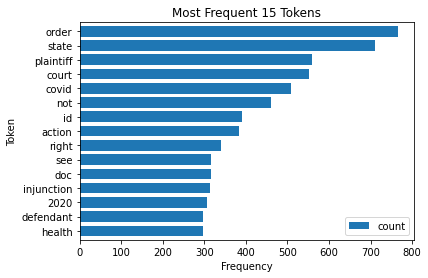

In [90]:
# Visualize most frequent words: frequency diagram using lemmas
barh_plot = unique_freq_df.head(15).plot.barh(x = 'token', y = 'count',  width = 0.75, title = 'Most Frequent 15 Tokens') 
barh_plot.invert_yaxis() # Puts largest at top of y axis
barh_plot.set(xlabel = 'Frequency', ylabel = 'Token') # Adds labels

In [91]:
# Word clouds
# Re-string whichever column you want to display if currently in tokenized form
dc_df['synopsis_toks_lemma_str'] = [' '.join(map(str, l)) for l in dc_df['synopsis_toks_lemma']]

# Convert to list
lemma_list = str(dc_df['synopsis_toks_lemma_str'].tolist())

In [92]:
# Define function to create a word cloud and save to file
# Resources: 
# https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f
# https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214

# Two methods for creating word clouds: from text or from table
# Here, from text.

def create_from_text_wordcloud(text, title):
    wordcloud = WordCloud(
        width = 750, 
        height = 500,
        max_words = 750, 
        background_color = 'white',
        collocations = False).generate(text)
    wordcloud.recolor(color_func = lambda *args, **kwargs: 'black')
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.savefig('wordcloud.png')
    plt.show()
    
# Note that you can also add an argument to drop a list of stopwords if you're just passing raw text to the WordCloud function
# stopwords= [your stop words object here]

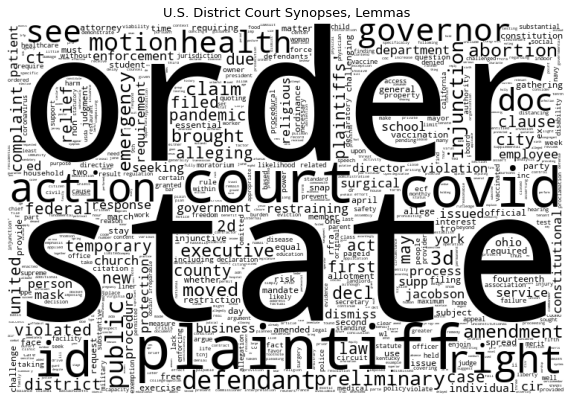

In [93]:
# Generate the word cloud
create_from_text_wordcloud(lemma_list, 'U.S. District Court Synopses, Lemmas')

# What are the pros and cons of word clouds?